Convnet Intro

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:

REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "CATS_V_DOGS/PetImages/Cat"
    DOGS = "CATS_V_DOGS/PetImages/Dog"
    LABELS = {CATS:0, DOGS: 1}

    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("Cats:" , self.catcount)
        print("Dogs:" , self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

100%|██████████| 12501/12501 [00:13<00:00, 904.04it/s]


CATS_V_DOGS/PetImages/Cat
CATS_V_DOGS/PetImages/Dog
Cats: 12476
Dogs: 12470


In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


In [4]:
print(training_data[0])

[array([[ 68,  60,  66, ..., 112, 140, 133],
       [ 61,  53,  62, ..., 117, 134, 142],
       [ 54,  61,  68, ..., 127, 129, 148],
       ...,
       [ 49,  80,  77, ..., 123, 110, 110],
       [ 59,  70,  83, ..., 121, 114, 120],
       [ 47,  81,  43, ..., 114,  95, 111]], dtype=uint8)
 array([0., 1.])]


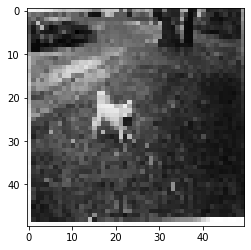

[0. 1.]


In [5]:
import matplotlib.pyplot as plt
num = 10000
plt.imshow(training_data[num][0], cmap='gray')
plt.show()
print(training_data[num][1])

to create one-hot vector

https://en.wikipedia.org/wiki/One-hot

In [6]:
np.eye(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))

        #rint(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = Net()

In [8]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

X= torch.Tensor([i[0] for i in training_data]). view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)


2494


In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))



22452
2494


train the net

In [15]:
BATCH_SIZE = 100

def train(net,epochs):
    for epoch in range(epochs):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(i, i+ BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs,batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. loss: {loss}")

100%|██████████| 225/225 [00:23<00:00,  9.58it/s]


tensor(0.1602, grad_fn=<MseLossBackward>)
tensor(0.1595, grad_fn=<MseLossBackward>)
tensor(0.1541, grad_fn=<MseLossBackward>)
tensor(0.1431, grad_fn=<MseLossBackward>)


test the net

In [16]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,50,50))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))


100%|██████████| 2494/2494 [00:04<00:00, 516.54it/s]


Accuracy:  0.68


In [18]:
torch.cuda.is_available()





torch.device